In [1]:
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from tabulate import tabulate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.svm import LinearSVC


In [2]:
# Veri Setini Yükleme
file_path = "phishing_site_urls.csv"  # Dosyanın bulunduğu yolu belirtin
df = pd.read_csv(file_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549346 entries, 0 to 549345
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   URL     549346 non-null  object
 1   Label   549346 non-null  object
dtypes: object(2)
memory usage: 8.4+ MB


In [4]:
print("\n Veri seti boyutu:")
print(df.shape)


 Veri seti boyutu:
(549346, 2)


In [5]:
# Etiket (Label) dağılımı
print("\n Etiket Dağılımı:")
print(df['Label'].value_counts())


 Etiket Dağılımı:
Label
good    392924
bad     156422
Name: count, dtype: int64


In [6]:
# Yinelenen satır sayısını bul
yinelenen_sayi = df.duplicated().sum()
print(f" Yinelenen kayıt sayısı: {yinelenen_sayi}")

 Yinelenen kayıt sayısı: 42150


In [7]:
df = df.drop_duplicates()
print(f" Yinelenen satırlar temizlendi. Yeni veri seti boyutu: {df.shape}")

 Yinelenen satırlar temizlendi. Yeni veri seti boyutu: (507196, 2)


In [8]:
print("Etiket dağılımı (Label):")
print(df['Label'].value_counts())

Etiket dağılımı (Label):
Label
good    392897
bad     114299
Name: count, dtype: int64


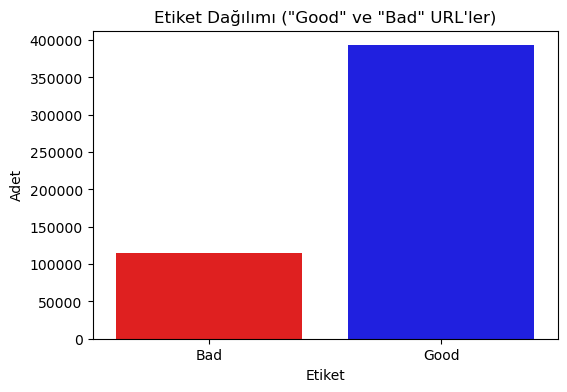

In [9]:
# Etiket dağılımı
plt.figure(figsize=(6,4))
sns.countplot(x=df['Label'], palette=['red', 'blue'])
plt.title('Etiket Dağılımı ("Good" ve "Bad" URL\'ler)')
plt.xlabel('Etiket')
plt.ylabel('Adet')
plt.xticks([0, 1], ["Bad", "Good"])
plt.show()

In [10]:
# Kategorik Değerlerin İşlenmesi
df['Label'] = df['Label'].map({'good': 1, 'bad': 0})

print(df.head())

                                                 URL  Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...      0
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...      0
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....      0
3  mail.printakid.com/www.online.americanexpress....      0
4  thewhiskeydregs.com/wp-content/themes/widescre...      0


In [11]:
X = df['URL']  # URL'ler
y = df['Label']  # Etiketler

In [22]:
# --- Vektörizerler ---
vectorizers = {
    "CountVectorizer": CountVectorizer(stop_words='english', max_features=5000),
    "TF-IDF":       TfidfVectorizer(stop_words='english', max_features=5000),
    "Hashing":      HashingVectorizer(n_features=5000, alternate_sign=False)
}

In [23]:
# --- Modeller ---
models = {
    "Naive Bayes":         MultinomialNB(),
    "Random Forest":       RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Linear SVC":          LinearSVC(random_state=42, max_iter=10000),
    "Gradient Boosting":   GradientBoostingClassifier(random_state=42),
    "KNN":                 KNeighborsClassifier(n_neighbors=5)
}

In [24]:
# --- K-fold ve skorlayıcılar ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

results = []

In [27]:
# 5-fold Stratified CV ayarı
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []


In [29]:
from collections import Counter

#her vektörizer + model kombinasyonu için
for vect_name, vect in vectorizers.items():
    for model_name, model in models.items():
        fold_acc, fold_prec, fold_rec, fold_f1 = [], [], [], []
        print(f"\n▶ {vect_name} + {model_name}")

        for fold, (train_idx, test_idx) in enumerate(kf.split(X, y), start=1):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Vektörizasyon
            X_tr_vect = vect.fit_transform(X_train)
            X_te_vect = vect.transform(X_test)

            # SMOTE
            X_res, y_res = SMOTE(random_state=42).fit_resample(X_tr_vect, y_train)
            print(f"  Fold {fold} sonrası dağılım: {dict(Counter(y_res))}")

            # Model eğit & tahmin
            model.fit(X_res, y_res)
            y_pred = model.predict(X_te_vect)

            # Metrikleri hesapla (zero_division=0 ile nan önle)
            fold_acc.append( accuracy_score(y_test, y_pred) )
            fold_prec.append( precision_score(y_test, y_pred, zero_division=0) )
            fold_rec.append(   recall_score(y_test, y_pred, zero_division=0) )
            fold_f1.append(    f1_score(y_test, y_pred, zero_division=0) )

        # Ortalama sonuçları kaydet
        results.append({
            "Vectorizer": vect_name,
            "Model":      model_name,
            "Accuracy":   np.mean(fold_acc),
            "Precision":  np.mean(fold_prec),
            "Recall":     np.mean(fold_rec),
            "F1-Score":   np.mean(fold_f1)
        })



▶ CountVectorizer + Naive Bayes
  Fold 1 sonrası dağılım: {0: 314317, 1: 314317}
  Fold 2 sonrası dağılım: {0: 314318, 1: 314318}
  Fold 3 sonrası dağılım: {0: 314318, 1: 314318}
  Fold 4 sonrası dağılım: {0: 314318, 1: 314318}
  Fold 5 sonrası dağılım: {0: 314317, 1: 314317}

▶ CountVectorizer + Random Forest
  Fold 1 sonrası dağılım: {0: 314317, 1: 314317}
  Fold 2 sonrası dağılım: {0: 314318, 1: 314318}
  Fold 3 sonrası dağılım: {0: 314318, 1: 314318}
  Fold 4 sonrası dağılım: {0: 314318, 1: 314318}
  Fold 5 sonrası dağılım: {0: 314317, 1: 314317}

▶ CountVectorizer + Logistic Regression
  Fold 1 sonrası dağılım: {0: 314317, 1: 314317}
  Fold 2 sonrası dağılım: {0: 314318, 1: 314318}
  Fold 3 sonrası dağılım: {0: 314318, 1: 314318}
  Fold 4 sonrası dağılım: {0: 314318, 1: 314318}
  Fold 5 sonrası dağılım: {0: 314317, 1: 314317}

▶ CountVectorizer + Linear SVC
  Fold 1 sonrası dağılım: {0: 314317, 1: 314317}
  Fold 2 sonrası dağılım: {0: 314318, 1: 314318}
  Fold 3 sonrası dağılım: 

In [30]:
# Tüm sonuçları tablo olarak yazdır
results_df = pd.DataFrame(results)
print("\n✅ K-Fold CV Sonuçları:")
print(tabulate(results_df, headers='keys', tablefmt='pretty'))


✅ K-Fold CV Sonuçları:
+----+-----------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|    |   Vectorizer    |        Model        |      Accuracy      |     Precision      |       Recall       |      F1-Score      |
+----+-----------------+---------------------+--------------------+--------------------+--------------------+--------------------+
| 0  | CountVectorizer |     Naive Bayes     | 0.9217363723751804 |  0.95850675921148  | 0.9396457564250073 | 0.9489817485475325 |
| 1  | CountVectorizer |    Random Forest    | 0.9290353232598058 | 0.9678257452371145 | 0.9396279430047121 | 0.9535182875613142 |
| 2  | CountVectorizer | Logistic Regression | 0.893658468809696  | 0.9793291860014632 | 0.8813251320847174 | 0.9277455726321785 |
| 3  | CountVectorizer |     Linear SVC      | 0.8937728220636897 | 0.979351229586508  | 0.8814549377579889 | 0.9278274986673614 |
| 4  | CountVectorizer |  Gradient Boosting  | 0.8582875253

In [34]:
best_idx = results_df['F1-Score'].idxmax()
best = results_df.loc[best_idx]

print("\nEn İyi Model:")
print(f"Vektörizer: {best['Vectorizer']}")
print(f"Model:      {best['Model']}")
print(f"Accuracy:   {best['Accuracy']:.4f}")
print(f"Precision:  {best['Precision']:.4f}")
print(f"Recall:     {best['Recall']:.4f}")
print(f"F1-Score:   {best['F1-Score']:.4f}")


En İyi Model:
Vektörizer: Hashing
Model:      Random Forest
Accuracy:   0.9519
Precision:  0.9656
Recall:     0.9726
F1-Score:   0.9691


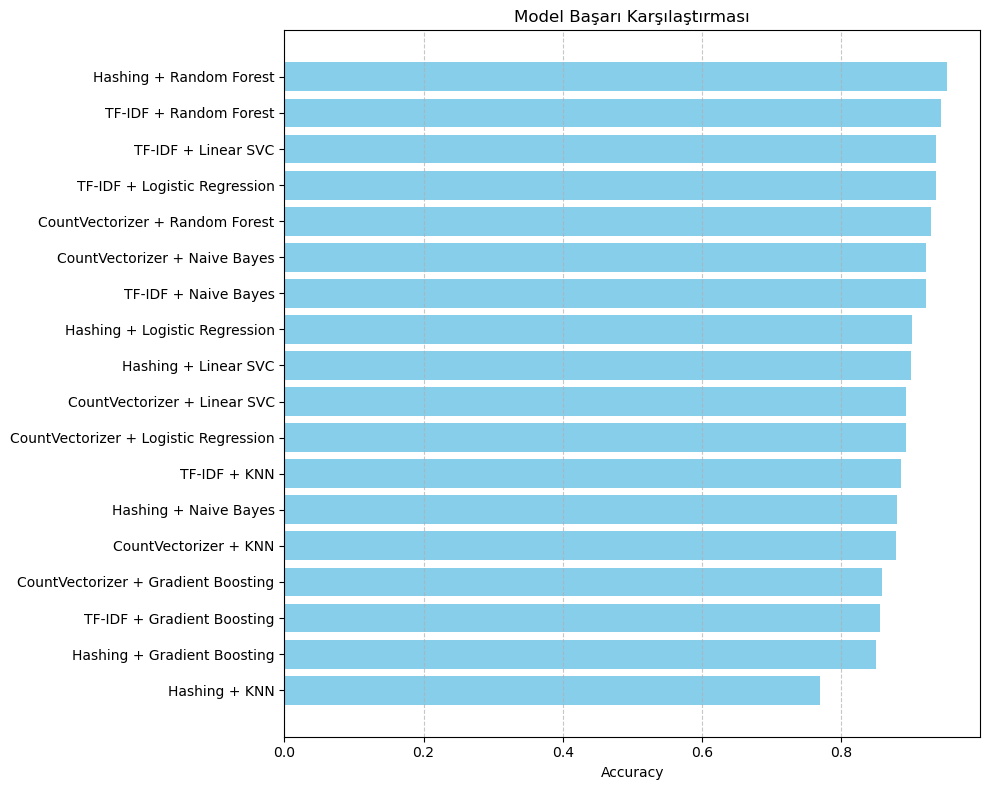

In [37]:
import pandas as pd
import matplotlib.pyplot as plt


# Sonuçları Accuracy'e göre sırala
sorted_results = results_df.sort_values(by="Accuracy", ascending=False)

# Bar chart ile Accuracy karşılaştırması
plt.figure(figsize=(10, 8))
y_labels = sorted_results['Vectorizer'] + " + " + sorted_results['Model']
plt.barh(y_labels, sorted_results['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Başarı Karşılaştırması')
plt.gca().invert_yaxis()  # En yüksek doğruluk en üstte
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
